### Bayesian Entropy Neural Network - Regression problem


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from bbb import BNN, BNNLayer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('regression_benn_mdmm_logs'):
    os.makedirs('regression_benn_mdmm_logs')
    


In [3]:

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        huber_condition = torch.abs(error) < self.delta
        loss = torch.where(huber_condition,
                           0.5 * error.pow(2),
                           self.delta * (torch.abs(error) - 0.5 * self.delta))
        return torch.mean(loss)

def fencon(eta, N, regressor, x_test, y_test):
    '''
    Compute loss with a value constraint
    '''
    I1 = 0
    I2 = 0
    for i in range(N):
        g = regressor(x_test)
        I1 += g*torch.exp(eta*g) # This can explode if eta is too large
        I2 += torch.exp(eta*g)
    
    # err = torch.abs(I1/I2 - y_test)
    I1 = I1/N
    I2 = I2/N
    
    # compute MSE loss - I1/I2 and y_test
    crit = nn.MSELoss()
    err = crit(I1/I2, y_test)

    return err

In [4]:
# # Bayesian Entropy Neural Network
# # Define NN model
# @variational_estimator
# class BayesianRegressor(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.posterior_rho_init = 2.0
#         self.blinear1 = BayesianLinear(input_dim, 100, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(1.0).to(device = torch.device('cuda:0'))))
#         self.blinear2 = BayesianLinear(100, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(1.0).to(device = torch.device('cuda:0'))))

#     def forward(self, x):
#         x_ = self.blinear1(x)
#         x_ = F.tanh(x_)
#         x_ = self.blinear2(x_)
#         return x_



In [5]:
sig_e = 0.1
nobs = 36
x = 10*np.random.rand(nobs)
ndim = 1
nd = (ndim+1)*(ndim+2)//2
from quad_basis import quad_basis
X = quad_basis(x)
e = sig_e*np.random.randn(nobs, 1)
beta_true = np.array([1,-2,1]).transpose().reshape(-1,1)
y = X@beta_true + e

X_train = x.reshape(-1,1)
y_train = y

# # create another X_train, y_train 
# x = np.random.uniform(-4, 4, size=20).reshape((-1, 1))
# noise = np.random.normal(0, 9, size=20).reshape((-1, 1))
# y = x ** 3 + noise

# X_train = x
# y_train = y


In [6]:
def value_constraints(data):
    X_test = np.array([vc[0] for vc in data]).reshape(-1, 1)
    y_test = np.array([vc[1] for vc in data]).reshape(-1, 1)
    return np.concatenate((X_test, y_test), axis=0)

X_test, y_test = value_constraints([[40, 33]])

In [7]:
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1000, shuffle=True)

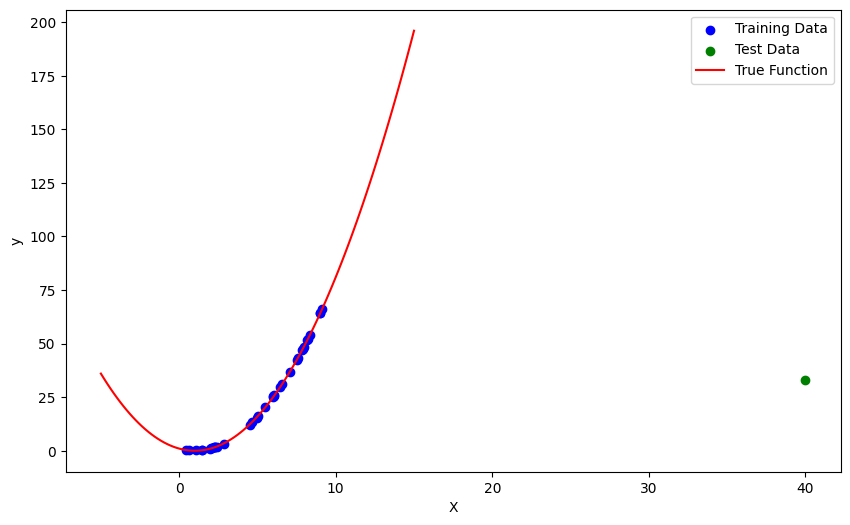

In [8]:
# Plot the training data and the true function 
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')
# plot the true function 
x_plot = np.linspace(-5, 15, 100)
# y_plot = x_plot ** 3
y_plot = quad_basis(x_plot)@beta_true
plt.plot(x_plot, y_plot, color='red', label='True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [9]:
next(iter(dataloader_train))[0].reshape(-1, 1).shape

torch.Size([36, 1])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BNN(BNNLayer(1, 1024, activation='relu', prior_mean=0, prior_rho=0),
            BNNLayer(1024, 1, activation='none', prior_mean=0, prior_rho=0)).to(device)


criterion = torch.nn.MSELoss()

regressor_benn = BNN(BNNLayer(1, 512, activation='tanh', prior_mean=0, prior_rho=0),
            BNNLayer(512, 1, activation='none', prior_mean=0, prior_rho=0)).to(device)
criterion_benn = torch.nn.MSELoss()


In [11]:
# mdmm constraint impl


def equality_constraint_fn_1(*args, **kwargs):
    predictions = regressor_benn(X_test.reshape(-1,1).to(device), mode = 'MC')
    return predictions.reshape(-1).squeeze()

def equality_constraint_fn_2(*args, **kwargs):
    '''
    Derivative constraint at x_c
    '''
    x_c = torch.tensor([40.0]).to(device)
    x_c.requires_grad_()
    predictions = regressor_benn(x_c.reshape(-1,1).to(device))
    # do a backward pass to get the derivative of predictions at x_c
    predictions.backward(retain_graph=True)
    der = x_c.grad.clone() 
    # zero out the gradients for all parameters that are affected by backward
    regressor_benn.zero_grad()
    x_c.grad.zero_()
    return der.squeeze()

def range_constraint_fn_1():
    x_c = torch.tensor([60.0]).to(device)
    predictions = regressor_benn(x_c.reshape(-1,1).to(device))
    return predictions.reshape(-1).squeeze()

value_constraint = mdmm.EqConstraint(equality_constraint_fn_1, y_test.squeeze().to(device))
derivative_constraint = mdmm.EqConstraint(equality_constraint_fn_2, torch.tensor(-5.0).to(device))
range_constraint = mdmm.BoundConstraintHard(range_constraint_fn_1, torch.tensor(30.0).to(device), torch.tensor(60.0).to(device))
mdmm_module = mdmm.MDMM([value_constraint])
opt = mdmm_module.make_optimizer(regressor_benn.parameters(), lr = 0.1)
# opt = torch.optim.Adam(regressor_benn.parameters(), lr=1e-3)


In [12]:
## Baseline result
# iteration = 0
# best_loss = 1e6
# regressor.train()
# for epoch in range(2500):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         optimizer.zero_grad()
#         datapoints = datapoints.reshape(-1, 1).to(device)
#         labels = labels.reshape(-1, 1).to(device)
#         loss = regressor.sample_elbo(inputs=datapoints.to(device),
#                            labels=labels.to(device),
#                            criterion=criterion,
#                            sample_nbr=3,
#                            complexity_cost_weight=1/X_train.shape[0])
#         # loss = criterion(regressor(datapoints), labels)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         # check if the loss is lower than the best_loss
#         if loss < best_loss:
#             best_loss = loss
#             best_model = regressor
#             print("Best loss: {:.4f}".format(best_loss))
#             print('iteration: ', iteration)
        
#         iteration += 1
#         if iteration%10==0:
#         #     ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
#         #                                                                 X_test.reshape(-1,1).to(device),
#         #                                                                 y_test.reshape(-1,1).to(device),
#         #                                                                 samples=25,
#         #                                                                 std_multiplier=3)
            
            
#             # print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
#             print("Loss: {:.4f}".format(loss))


In [ ]:
def calculate_variance(x, training_data, sigma, length_scale):
    # Calculate the distance from x to the nearest training data point
    distance = torch.min(torch.norm(training_data - x, dim=1))
    
    # Apply the SE function to calculate variance
    variance = sigma**2 * torch.exp(-distance**2 / (2 * length_scale**2))
    return variance

import time
iteration = 0
best_loss = 1e6


N = 3
regressor_benn.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('regression_benn_mdmm_logs/' + current_time)
time_elapsed_ = []
for epoch in range(2500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        start_time = time.time()
        # loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
        #                    labels=labels.to(device),
        #                    criterion=criterion_benn,
        #                    sample_nbr=3,
        #                    complexity_cost_weight=1/X_train.shape[0])
        
        kl_div, log_likelihood = regressor_benn.Forward(datapoints, labels, 1, 'Gaussian')
        loss_data = BNN.loss_fn(kl_div, log_likelihood, 1)
        mdmm_return = mdmm_module(loss_data)
        opt.zero_grad()
        mdmm_return.value.backward()
        opt.step()
        # check if the loss is lower than the best_loss
        if mdmm_return.value.item() < best_loss:
            best_loss = loss_data
            best_model = regressor_benn
        
        # save history
        loss_data_history.append(loss_data.item())
        iteration += 1
        end_time = time.time()
        time_elapsed_.append(end_time - start_time)
        # print('Time elapsed for one iteration: {:.4f}'.format(end_time - start_time))
        if iteration%10==0:
            print("Loss: {:.4f} Loss_data: {:.4f} Constraint_Fn_Value: {:.4f} Infeasibility: {:.4f}".format(mdmm_return.value.item(), 
                                                                                                            loss_data.item(), mdmm_return.fn_values[0].item(), 
                                                                                                            mdmm_return.infs[0].item()))
            print('-----------------------------')
            writer.add_scalar('Loss/loss_data', loss_data.item(), iteration)
            writer.add_scalar('Loss/total_loss', mdmm_return.value.item(), iteration)
            writer.add_scalar('Loss/constraint_fn_value', mdmm_return.fn_values[0].item(), iteration) # TODO: assuming one constraint. What if there are multiple constraints?
            writer.add_scalar('Constraint Infeasibility', mdmm_return.infs[0].item(), iteration)
            writer.add_scalar('Lagrange Multiplier', mdmm_module[0].lmbda.item(), iteration)
            writer.flush()


In [13]:
# import time
# iteration = 0
# best_loss = 1e6


# N = 3
# regressor_benn.train()

# eta_history = []
# loss_history = []
# loss_data_history = []
# loss_constraint_history = []

# best_loss = 1e9
# # create summary writer based on datetime
# import datetime
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# writer = SummaryWriter('regression_benn_mdmm_logs/' + current_time)
# time_elapsed_ = []
# for epoch in range(2500):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         datapoints = datapoints.reshape(-1, 1).to(device)
#         labels = labels.reshape(-1, 1).to(device)
#         start_time = time.time()
#         # loss_data = regressor_benn.sample_elbo(inputs=datapoints.to(device),
#         #                    labels=labels.to(device),
#         #                    criterion=criterion_benn,
#         #                    sample_nbr=3,
#         #                    complexity_cost_weight=1/X_train.shape[0])
        
#         kl_div, log_likelihood = regressor_benn.Forward(datapoints, labels, 1, 'Gaussian')
#         loss_data = BNN.loss_fn(kl_div, log_likelihood, 1)
#         mdmm_return = mdmm_module(loss_data)
#         opt.zero_grad()
#         mdmm_return.value.backward()
#         opt.step()
#         # check if the loss is lower than the best_loss
#         if mdmm_return.value.item() < best_loss:
#             best_loss = loss_data
#             best_model = regressor_benn
        
#         # save history
#         loss_data_history.append(loss_data.item())
#         iteration += 1
#         end_time = time.time()
#         time_elapsed_.append(end_time - start_time)
#         # print('Time elapsed for one iteration: {:.4f}'.format(end_time - start_time))
#         if iteration%10==0:
#             print("Loss: {:.4f} Loss_data: {:.4f} Constraint_Fn_Value: {:.4f} Infeasibility: {:.4f}".format(mdmm_return.value.item(), 
#                                                                                                             loss_data.item(), mdmm_return.fn_values[0].item(), 
#                                                                                                             mdmm_return.infs[0].item()))
#             print('-----------------------------')
#             writer.add_scalar('Loss/loss_data', loss_data.item(), iteration)
#             writer.add_scalar('Loss/total_loss', mdmm_return.value.item(), iteration)
#             writer.add_scalar('Loss/constraint_fn_value', mdmm_return.fn_values[0].item(), iteration) # TODO: assuming one constraint. What if there are multiple constraints?
#             writer.add_scalar('Constraint Infeasibility', mdmm_return.infs[0].item(), iteration)
#             writer.add_scalar('Lagrange Multiplier', mdmm_module[0].lmbda.item(), iteration)
#             writer.flush()


/home/paralab/.local/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss: 8368.6133 Loss_data: 8264.6553 Constraint_Fn_Value: 48.0250 Infeasibility: -15.0250
-----------------------------
Loss: 4943.4229 Loss_data: 4929.3784 Constraint_Fn_Value: 38.9983 Infeasibility: -5.9983
-----------------------------
Loss: 4431.1338 Loss_data: 4391.3252 Constraint_Fn_Value: 42.4686 Infeasibility: -9.4686
-----------------------------
Loss: 4622.4355 Loss_data: 4484.1807 Constraint_Fn_Value: 49.8540 Infeasibility: -16.8540
-----------------------------
Loss: 4274.0918 Loss_data: 4271.7061 Constraint_Fn_Value: 35.0734 Infeasibility: -2.0734
-----------------------------
Loss: 4217.0503 Loss_data: 4135.0610 Constraint_Fn_Value: 45.3881 Infeasibility: -12.3881
-----------------------------
Loss: 4229.8594 Loss_data: 4173.4424 Constraint_Fn_Value: 42.9378 Infeasibility: -9.9378
-----------------------------
Loss: 4209.0337 Loss_data: 4027.9341 Constraint_Fn_Value: 50.9883 Infeasibility: -17.9883
-----------------------------
Loss: 3762.1152 Loss_data: 3748.8391 Constra

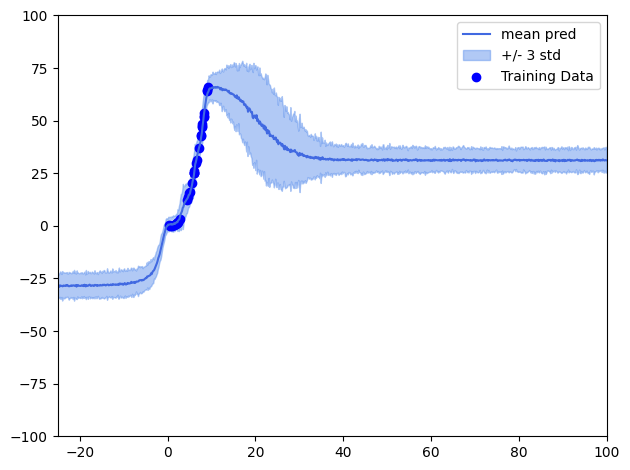

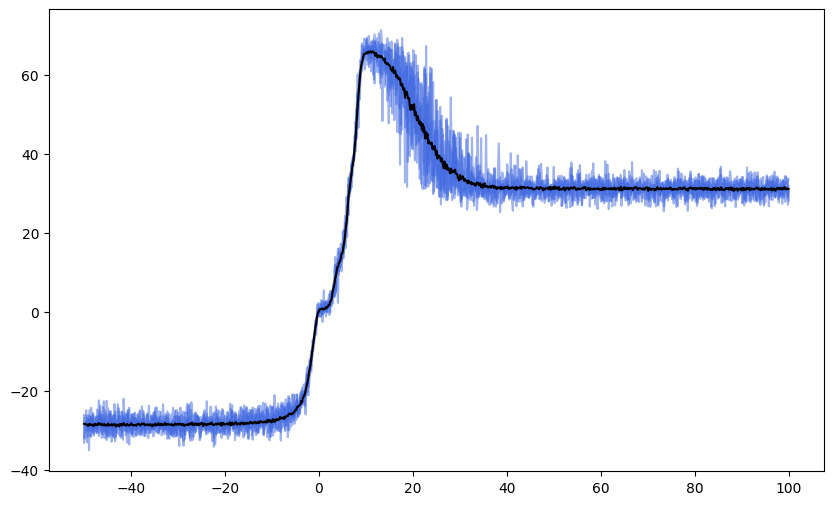

In [25]:
# Forward mode for the new bnn 
x_ = torch.linspace(-50, 100, 1000).reshape(-1,1).to(device)
# y_ = x_ ** 3
y_ = quad_basis(x_.data.cpu().numpy().ravel())@beta_true

pred_lst = [best_model.forward(x_, mode='MC').data.cpu().numpy().squeeze(1) for _ in range(100)]

pred = np.array(pred_lst).T
pred_mean = pred.mean(axis=1)
pred_std = pred.std(axis=1)
plt.plot(x_.data.cpu().numpy().ravel(), pred_mean, c='royalblue', label='mean pred')
plt.fill_between(x_.data.cpu().numpy().ravel(), pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                    color='cornflowerblue', alpha=.5, label='+/- 3 std')

# plt.plot(x_.data.cpu().numpy().ravel(), y_, c='grey', label='truth')
# plot the training data
plt.scatter(X_train.data.cpu().numpy().ravel(), y_train.data.cpu().numpy().ravel(), color='blue', label='Training Data')
# plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)

plt.xlim(-25, 100)
plt.ylim(-100, 100)

plt.legend()
plt.tight_layout()

# draw samples from the posterior for all x_
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(x_.data.cpu().numpy().ravel(), pred[:, i], c='royalblue', alpha=0.5)

plt.plot(x_.data.cpu().numpy().ravel(), pred_mean, c='black', label='mean pred')



In [ ]:
mean_time_elapsed = np.mean(time_elapsed_)
print('Mean time elapsed: {:.4f}'.format(mean_time_elapsed))

TypeError: forward() missing 1 required positional argument: 'mode'

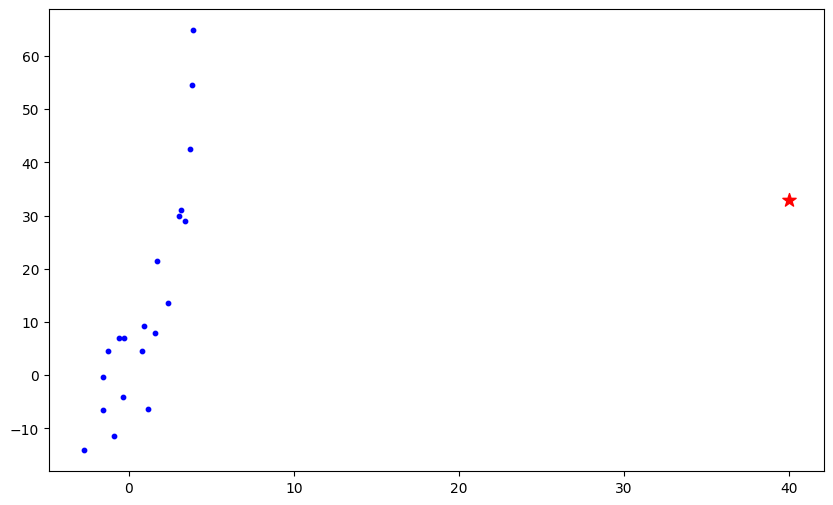

In [22]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)
# plt.scatter(60.0, 30.0, color='green', label='Range Constraint - Lower Bound', marker='*', s=100)
# plt.scatter(60.0, 60.0, color='green', label='Range Constraint - Upper Bound', marker='*', s=100)
# linspaced test data
x_plot = torch.linspace(-5, 100, 1000).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model.forward(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (50*std_benn)
ci_lower_benn = mean_benn - (50*std_benn)

# Compute MSE loss on train, test set and constraint set
mae_loss = nn.L1Loss()
loss_training = []
loss_val_constraints = []
for i in range(100):
    loss_training.append(mae_loss(best_model(X_train.to(device)), y_train.to(device)))
    loss_val_constraints.append(mae_loss(best_model(X_test.to(device)).reshape(len(X_test),), y_test.to(device)))
print('Training loss: ', torch.stack(loss_training).mean())
print('Val constraint loss: ', torch.stack(loss_val_constraints).mean())

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.5)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# plot just the variance and the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.plot(x_plot, 10*std_benn, color='red', label='Variance of Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


# Plot loss histories 
'''
loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))
# loss_constraint_3_history   = (loss_constraint_3_history - min(loss_constraint_3_history))/(max(loss_constraint_3_history) - min(loss_constraint_3_history))
plt.figure(figsize=(10, 6))
plt.plot(loss_data_history, color='blue', label='Data Loss')
plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# plt.plot(loss_constraint_2_history, color='red', label='Constraint 2 Loss')
# plt.plot(loss_constraint_3_history, color='yellow', label='Constraint 3 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot eta history
plt.figure(figsize=(10, 6))
plt.plot(eta_history, color='blue', label='eta')
plt.xlabel('Iteration')
plt.ylabel('eta')
plt.legend()
plt.show()

'''

In [17]:
std_benn

array([[0.01494852],
       [0.01486591],
       [0.01479818],
       [0.0147482 ],
       [0.01471694],
       [0.01470464],
       [0.01471299],
       [0.01474189],
       [0.01478776],
       [0.01484865],
       [0.01491913],
       [0.0149922 ],
       [0.01505867],
       [0.01510868],
       [0.0151307 ],
       [0.01511292],
       [0.01504592],
       [0.01492106],
       [0.01473202],
       [0.01447877],
       [0.01416356],
       [0.01379425],
       [0.01338231],
       [0.01294336],
       [0.01249423],
       [0.01205094],
       [0.01162975],
       [0.01124391],
       [0.0109034 ],
       [0.01061372],
       [0.01037609],
       [0.01018957],
       [0.01004947],
       [0.00994903],
       [0.00988218],
       [0.00984223],
       [0.00982262],
       [0.00981822],
       [0.00982441],
       [0.0098378 ],
       [0.00985597],
       [0.00987678],
       [0.00989881],
       [0.00992143],
       [0.00994336],
       [0.00996478],
       [0.00998471],
       [0.010

In [ ]:
# find the values of x_plot between 30 and 31
x_plot_ = x_plot[(x_plot>=30) & (x_plot<=31)]
# extract the corresponding values of mean_benn 
mean_benn_ = mean_benn[(x_plot>=30) & (x_plot<=31)]
print("x_plot_", x_plot_, 'mean_benn_: ', mean_benn_)


## Using BO-Torch to optimize eta and the model simultaneously


In [ ]:
def initialize_model():
    regressor_benn = BayesianRegressor(1, 1).to(device)
    return regressor_benn

def initialize_optimizer(model):
    optimizer_benn = optim.Adam(model.parameters(), lr=0.005)
    scheduler_benn = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.25)
    return optimizer_benn, scheduler_benn

def compute_loss(datapoints, labels, model, eta):
    N = 3
    # loss_data = criterion(model(datapoints), labels)
    loss_data = model.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
    loss_constraint_1 = fencon(eta, N, model, X_test.reshape(-1,1).to(device), y_test.reshape(-1,1).to(device))
    # loss_constraint_2 = fencon3(eta, N, model, X_test_3.reshape(-1,1).to(device), dy_test_3.reshape(-1,1).to(device))
    # loss = loss_data + loss_constraint_1 + loss_constraint_2
    loss = loss_data + loss_constraint_1
    return loss


In [ ]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

# Define your objective function (validation loss in this case)
num_epochs = 2
def objective(eta):
    model = initialize_model()
    optimizer, scheduler = initialize_optimizer(model)
    best_loss = 1e6
    for epoch in range(num_epochs):
        for i, (datapoints, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()
            loss = compute_loss(datapoints, labels, model, eta)
            loss.backward()
            optimizer.step()
            # check if the loss is lower than the best_loss
        if loss < best_loss:
            best_loss = loss
            best_model_benn = regressor_benn
            print("Best loss: {:.4f}".format(best_loss))
            print('iteration: ', epoch)
    

    # validation_loss = compute_validation_loss(validation_data, model)
    return loss.item()


# Define the range for eta
eta_lower = 0.1
eta_upper = 0.9

# Create training data for eta
eta_range = torch.linspace(eta_lower, eta_upper, steps=50).reshape(-1, 1)  # Adjust the number of steps as needed

# Create corresponding target values using the objective function
train_X = eta_range
train_Y = torch.tensor([objective(eta.item()) for eta in eta_range], dtype=torch.float).reshape(-1, 1)
# Initialize the SingleTaskGP model
model = SingleTaskGP(train_X, train_Y)

# Define the acquisition function
acquisition = ExpectedImprovement(model, best_f = 0.2, maximize=False)

# Optimize the acquisition function
best_eta, _ = optimize_acqf(
    acq_function=acquisition,
    bounds=torch.tensor([[eta_lower], [eta_upper]]),  # eta values are bounded between 0.1 and 0.9
    q=1,  # Number of candidates to select
    num_restarts=10,  # Number of optimization restarts
    raw_samples=500,  # Number of random samples for initialization
)

print("Best eta:", best_eta.item())


In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
# size of scatter points = 10, and test points need to be stars not circles
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
plt.scatter(X_test, y_test, color='red', label='Test Data', marker='*', s=100)

# linspaced test data
x_plot = torch.linspace(-25, 100, 500).reshape(-1,1)

# y_plot = best_model(x_plot.to(device)).cpu().detach().numpy()
# preds = [best_model(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# std = preds.std(axis=0)
# ci_upper = mean + (1 * std)
# ci_lower = mean - (1 * std)

# y_plot_benn = best_model_benn(x_plot.to(device)).cpu().detach().numpy()
preds_benn = [best_model_benn(x_plot.to(device)).cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (1*std_benn)
ci_lower_benn = mean_benn - (1*std_benn)

# extract x_plot values between 25 and 27
# x_plot_deriv = x_plot[(x_plot>=10) & (x_plot<=11)]
# # compute line with slope dy_test_3, and y-intercept at mean_benn of x_plot_deriv >= 25 and <= 25.50
# y_plot_deriv = dy_test_3*(x_plot_deriv)


# plt.plot(x_plot, mean, color='red', label='Learned Function')
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='orange', alpha=0.25)
plt.plot(x_plot, mean_benn, color='yellow', label='Learned Function with BENN Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='blue', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# # Plot loss histories 
# loss_data_history = (loss_data_history - np.min(loss_data_history))/(np.max(loss_data_history) - np.min(loss_data_history))
# loss_constraint_1_history = (loss_constraint_1_history - np.min(loss_constraint_1_history))/(np.max(loss_constraint_1_history) - np.min(loss_constraint_1_history))
# # loss_constraint_2_history = (loss_constraint_2_history - min(loss_constraint_2_history))/(max(loss_constraint_2_history) - min(loss_constraint_2_history))

# plt.figure(figsize=(10, 6))
# plt.plot(loss_data_history, color='blue', label='Data Loss')
# plt.plot(loss_constraint_1_history, color='green', label='Constraint 1 Loss')
# # # plt.plot(loss_constraint_2_history.cpu().detach().numpy(), color='red', label='Constraint 2 Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot eta history
# plt.figure(figsize=(10, 6))
# plt.plot(eta_history, color='blue', label='eta')
# plt.xlabel('Iteration')
# plt.ylabel('eta')
# plt.legend()
# plt.show()
